In [2]:



import wandb
import pandas as pd
import re
import datetime
from dateutil import relativedelta
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import math

def get_month(file_name):
    """
    This function extracts the month from a date string in a file name.
    This function takes a file name as input and searches for a date string in the format YYYYMMDDTHHMMSS (YearMonthDayTHourMinuteSecond). 
    It then extracts this date and calculates the number of months between January 1st of that year and the given date. 
    The function returns this month value as an integer. Note that months are 1-indexed,
    so January is represented as 1, February as 2, and so on.

    Parameters:
    file_name (str): The name of the file which contains a date string.

    Returns:
    int: The month of the year extracted from the date string in the file name.

    """
    # Compile a regular expression pattern into a regular expression object, 
    # which can be used for matching using its match() and search() methods.
    pattern = re.compile(r'\d{8}T\d{6}')

    # Search for the first match in the string
    match = re.search(pattern, file_name)

    # Get the matched string
    first_date = match.group(0)

    # parse the date string into a datetime object
    date = datetime.datetime.strptime(first_date, "%Y%m%dT%H%M%S")

    # calculate the number of days between January 1st and the given date

    delta = relativedelta.relativedelta(date, datetime.datetime(date.year, 1, 1))

    # Return the month (1-indexed)
    return delta.months+1


def convert_to_df(data_dic):
        """
        This function converts a the dictionary of data given by performace_per_month to a dataframe.
        Not all information is conserved. 

        Parameters:
        data_dic (dict): The dictionary containing the data to be converted.

        Returns:
        pd.DataFrame: A DataFrame containing the data from the input dictionary.
        """
    
        data = {'months':data_dic['months'],
                'Combine Score Avg':data_dic['Combine Score']['avg'],
                'Combine Score Std':data_dic['Combine Score']['std'],
                'SIC Avg':data_dic['SIC']['avg'],
                'SIC Std':data_dic['SIC']['std'],
                'SOD Avg':data_dic['SOD']['avg'],
                'SOD Std':data_dic['SOD']['std'],
                'FLOE Avg':data_dic['FLOE']['avg'],
                'FLOE Std':data_dic['FLOE']['std'],
                'sample _number':data_dic['sample_num']
                }
        return pd.DataFrame(data)

def performace_per_month(path,group):
    """
    This function calculates the average performance scores per month for a given group of runs.

    Parameters:
    path (str): The path to the runs in the Weights & Biases (wandb) project.
    group (str): The group of runs to consider.

    Returns:
    mean_dic: A dictionary containing the following:
        - months: list of the months (1,2,3,4..) that are in the data.
        - Metrics ( Combine Score, SIC, SOD, and FLOE). Each metric contains the following
            - Avg: The average score for each month
            - Std: The Standard deviation for each month
            - Array: All the scores belonging to each month. A list of numpy arrays. 
        - Sample Number: The number of scenes for each month. A list of positive intergers
        - Scenes: The name of the scenes used in each month. A list of lists. Each inner list containing the names of the scenes. 
    the average scores and standard deviations for each metric per month.
    relative_mean_dic: The only difference is that is measure the increase or decrease performace relative to the mean of each run
    """

    # open the wandb api
    api = wandb.Api()

    # Get the runs
    runs = api.runs(path=path,filters={'group':group})
    
    # Log all the validation artifacts
    val_df=[]

    # Get the validation tables for each run
    for run in runs:
        artifacts = run.logged_artifacts()

        # Try to get the artifacts in each run. Sometimes it is not possible. 
        try:
            for artifact in artifacts:


                    if artifact.type == 'run_table':
                        if 'val' in artifact.name:
                            df = artifact.get('val results table').get_dataframe()
                            df.attrs = {'name':run.id}
                            val_df.append(df)
                            print('appended val table')
        except:
            print(f'Error happened. Run:{run}')

    # Subtract the mean of each table
    val_mean_df = val_df
    val_relative_mean_df = []

    for df in val_df:
        mean_values = df.iloc[:,1:].mean()
        df_mean_sub = df.copy()
        df_mean_sub.iloc[:,1:] = df_mean_sub.iloc[:,1:] - mean_values
        val_relative_mean_df.append(df_mean_sub)
    
    # Calculate the avg scores per month
    avg_scores_by_month = {}
    relative_avg_scores_by_month = {}

    # Create the dictionaries that will hold the data
    dic = {'array':[],'avg':None,'std':None}
    metrics =  ['Combine Score','SIC','SOD','FLOE',]

    # Create the dictionaries to store the data
    for i in range(1,13):
        avg_scores_by_month[i] = {'Combine Score':deepcopy(dic), 'SIC':deepcopy(dic), 'SOD':deepcopy(dic), 'FLOE':deepcopy(dic),'scenes':[],'sample_num':0}
        relative_avg_scores_by_month[i] = {'Combine Score':deepcopy(dic),'SIC':deepcopy(dic),'SOD':deepcopy(dic),'FLOE':deepcopy(dic),'scenes':[],'sample_num':0}


    # Add all the scores and scenes by month
    for df in val_mean_df:
        for i in range(0,df.shape[0]):
            month = get_month(df.loc[i,'Scene'])
            avg_scores_by_month[month]['scenes'].append(df.loc[i,'Scene'])
            if math.isnan(df.loc[i,'Combine Score']):
                continue
            for metric in metrics:
                avg_scores_by_month[month][metric]['array'].append(df.loc[i,metric])
  
    
        


    # Add all the scores, scenes by month for relative scores
    for df in val_relative_mean_df:
        for i in range(0,df.shape[0]):
            month = get_month(df.loc[i,'Scene'])
            if math.isnan(df.loc[i,'Combine Score']):
                continue
            for metric in metrics:
                relative_avg_scores_by_month[month][metric]['array'].append(df.loc[i,metric])

        

    # Obtain the average and std
    for month_dict in avg_scores_by_month.values():
        month_dict['sample_num'] =  len(month_dict[metrics[0]]['array'])
        for metric_dict in month_dict.values():
            if isinstance(metric_dict,dict):
                metric_dict['array'] = np.array(metric_dict['array'])
                metric_dict['avg'] = metric_dict['array'].mean()
                metric_dict['std'] = metric_dict['array'].std()

    for month_dict in relative_avg_scores_by_month.values():
        month_dict['sample_num'] =  len(month_dict[metrics[0]]['array'])
        for metric_dict in month_dict.values():
            if isinstance(metric_dict,dict):
                metric_dict['array'] = np.array(metric_dict['array'])
                metric_dict['avg'] = metric_dict['array'].mean()
                metric_dict['std'] = metric_dict['array'].std()

    # Convert the format of the data instead of a dictionary into a lists for easier ploting
    mean_dic = {'months':[],
                'Combine Score':{'avg':[],'std':[],'array':[]},
                'SIC':{'avg':[],'std':[],'array':[]},
                'SOD':{'avg':[],'std':[],'array':[]},
                'FLOE':{'avg':[],'std':[],'array':[]},
                'scenes':[],
                'sample_num':[]
    }

    relative_mean_dic = {'months':[],
                'Combine Score':{'avg':[],'std':[],'array':[]},
                'SIC':{'avg':[],'std':[],'array':[]},
                'SOD':{'avg':[],'std':[],'array':[]},
                'FLOE':{'avg':[],'std':[],'array':[]},
                'scenes':[],
                'sample_num':[]
    }



    for month in avg_scores_by_month.keys():

        mean_dic['months'].append(month)

        [cs,sic,sod,floe,sc,sn] = avg_scores_by_month[month].keys()

        mean_dic[cs]['avg'].append(avg_scores_by_month[month][cs]['avg'])
        mean_dic[cs]['std'].append(avg_scores_by_month[month][cs]['std'])
        mean_dic[cs]['array'].append(avg_scores_by_month[month][cs]['array'])

        mean_dic[sic]['avg'].append(avg_scores_by_month[month][sic]['avg'])
        mean_dic[sic]['std'].append(avg_scores_by_month[month][sic]['std'])
        mean_dic[sic]['array'].append(avg_scores_by_month[month][sic]['array'])


        mean_dic[sod]['avg'].append(avg_scores_by_month[month][sod]['avg'])
        mean_dic[sod]['std'].append(avg_scores_by_month[month][sod]['std'])
        mean_dic[sod]['array'].append(avg_scores_by_month[month][sod]['array'])

        mean_dic[floe]['avg'].append(avg_scores_by_month[month][floe]['avg'])
        mean_dic[floe]['std'].append(avg_scores_by_month[month][floe]['std'])
        mean_dic[floe]['array'].append(avg_scores_by_month[month][floe]['array'])


        mean_dic[sn].append(avg_scores_by_month[month][sn])
        mean_dic[sc].append(avg_scores_by_month[month][sc])

    for month in relative_avg_scores_by_month.keys():

        relative_mean_dic['months'].append(month)

        [cs,sic,sod,floe,sc,sn] = relative_avg_scores_by_month[month].keys()

        relative_mean_dic[cs]['avg'].append(relative_avg_scores_by_month[month][cs]['avg'])
        relative_mean_dic[cs]['std'].append(relative_avg_scores_by_month[month][cs]['std'])
        relative_mean_dic[cs]['array'].append(relative_avg_scores_by_month[month][cs]['array'])

        relative_mean_dic[sic]['avg'].append(relative_avg_scores_by_month[month][sic]['avg'])
        relative_mean_dic[sic]['std'].append(relative_avg_scores_by_month[month][sic]['std'])
        relative_mean_dic[cs]['array'].append(relative_avg_scores_by_month[month][cs]['array'])

        relative_mean_dic[sod]['avg'].append(relative_avg_scores_by_month[month][sod]['avg'])
        relative_mean_dic[sod]['std'].append(relative_avg_scores_by_month[month][sod]['std'])
        relative_mean_dic[sod]['array'].append(relative_avg_scores_by_month[month][sod]['array'])
        

        relative_mean_dic[floe]['avg'].append(relative_avg_scores_by_month[month][floe]['avg'])
        relative_mean_dic[floe]['std'].append(relative_avg_scores_by_month[month][floe]['std'])
        relative_mean_dic[floe]['array'].append(relative_avg_scores_by_month[month][floe]['array'])



        relative_mean_dic[sn].append(relative_avg_scores_by_month[month][sn])
        relative_mean_dic[sc].append(relative_avg_scores_by_month[month][sc])

    return mean_dic , relative_mean_dic


In [10]:


path = 'ai4arctic/feature_selection_enviroment_rerun'
group = 'HH_HV_only'

HH_HV_mean_dic, HH_HV_relative_mean_dic = performace_per_month(path,group)


path = 'ai4arctic/feature_selection_time_rerun'
group = 'HH_HV_Time'

Time_mean_dic, Time_relative_mean_dic = performace_per_month(path,group)


path = 'ai4arctic/feature_selection_base'
group = 'HH_HV_Time_Location'

Time_Location_mean_dic, Time_Location_relative_mean_dic = performace_per_month(path,group)



wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table
Error happened. Run:<Run ai4arctic/feature_selection_enviroment_rerun/ud439qyx (finished)>


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


,months,Combine Score Avg,Combine Score Std,SIC Avg,SIC Std,SOD Avg,SOD Std,FLOE Avg,FLOE Std,sample _number
0,1,77.106860,16.642786,91.125078,8.490607,67.146813,28.151841,68.990985,28.744147,64
1,2,87.362734,13.930007,97.010776,2.602643,79.588388,24.829383,83.615286,21.056646,49
2,3,86.295239,12.075546,95.034000,4.271380,77.088848,27.237464,87.230131,11.380937,46
3,4,87.622311,8.600215,89.779262,8.944164,87.580705,11.411064,83.391672,12.777634,61
4,5,86.773521,11.877696,90.542890,7.554138,85.502261,16.639593,81.777301,22.081163,73
5,6,86.509907,9.483437,88.182884,12.152354,87.180070,9.334730,81.823325,19.121936,43
6,7,82.078969,19.765074,84.394508,26.749611,83.401708,17.614115,74.802400,20.477775,65
7,8,87.397505,14.257882,90.435394,11.372527,86.220151,18.720941,83.676293,19.724826,99
8,9,92.459363,11.422818,94.598920,8.156861,91.995806,13.662884,89.107487,18.741730,113
9,10,90.269275,12.820471,91.758813,11.875330,88.442850,17.301641,90.943025,13.868728,80


,months,Combine Score Avg,Combine Score Std,SIC Avg,SIC Std,SOD Avg,SOD Std,FLOE Avg,FLOE Std,sample _number
0,1,87.600170,10.464055,92.448042,8.666998,85.118107,14.679380,82.868489,19.841412,47
1,2,87.994791,11.879931,95.987791,2.799928,82.116024,22.221893,83.766489,17.741554,43
2,3,90.362120,6.990174,94.145620,5.253333,87.444120,12.460103,88.630860,9.878581,50
3,4,90.460625,5.949910,93.149251,6.123267,90.926475,8.901754,84.151925,13.584984,40
4,5,91.667591,5.402287,92.050682,6.053017,92.658091,8.853661,88.920431,13.583374,44
5,6,87.024657,11.746708,87.903800,12.481525,87.666943,16.947688,83.981914,15.623813,35
6,7,82.600754,18.140580,84.899842,21.405428,83.239842,21.054344,76.724439,21.452227,57
7,8,89.642688,12.777883,93.019968,7.861718,88.727441,17.598822,84.718806,19.420824,93
8,9,93.372894,7.618106,94.712941,6.907407,93.638871,8.339651,90.160847,14.837751,85
9,10,93.101338,7.761362,93.195352,7.079669,92.815873,9.982541,93.484212,9.714221,71


,months,Combine Score Avg,Combine Score Std,SIC Avg,SIC Std,SOD Avg,SOD Std,FLOE Avg,FLOE Std,sample _number
0,1,86.732491,13.082947,92.818091,7.696037,83.100636,19.523915,81.825091,23.835882,55
1,2,89.123294,12.197283,95.936510,2.711842,84.107333,21.719771,85.529235,19.040618,51
2,3,92.011776,5.782858,94.582939,4.201112,89.976653,10.215936,90.939653,8.953561,49
3,4,90.569661,6.985963,91.996286,5.956033,91.654965,10.806452,85.546089,12.179540,56
4,5,91.201140,7.299908,91.381702,5.903207,92.843895,11.608573,87.554474,15.834190,57
5,6,89.376119,8.936371,88.083118,12.150813,93.331424,6.733528,84.051628,15.320308,59
6,7,88.567000,9.303620,90.363333,6.989537,90.088233,9.749802,81.931917,18.781235,60
7,8,90.546500,11.386560,92.543875,10.808185,90.873448,13.645382,85.897917,16.852395,96
8,9,88.942100,13.436313,89.855619,16.125694,88.703173,14.408420,87.592564,15.948574,110
9,10,93.827346,7.390960,94.462559,7.028825,94.209173,8.486084,91.793387,12.638282,75


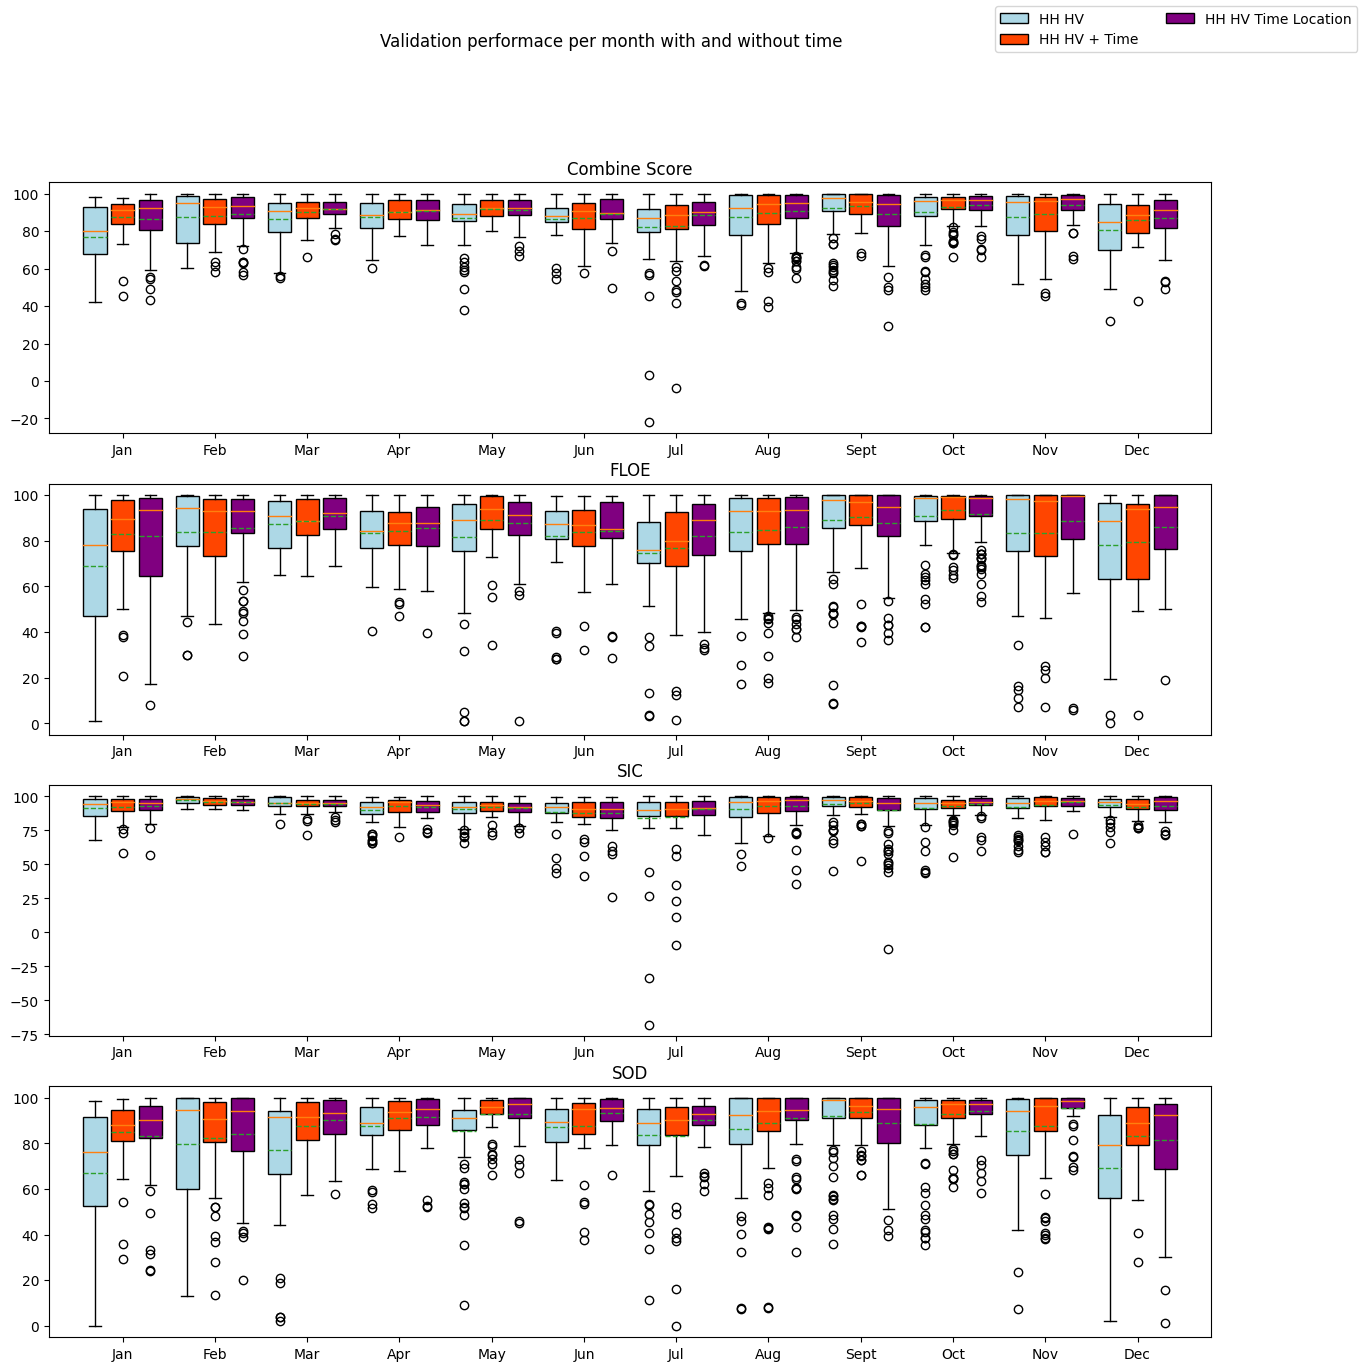

In [36]:

    
df_HH_HV = convert_to_df(HH_HV_mean_dic)
display(df_HH_HV)
df_HH_HV.to_csv('HH_HV_only.csv',index=False)

df_time = convert_to_df(Time_mean_dic)
display(df_time)
df_time.to_csv('HH_HV_Time.csv',index=False)


df_time_location = convert_to_df(Time_Location_mean_dic)
display(df_time_location)
df_time_location.to_csv('HH_HV_Time_Location.csv',index=False)


bar_width = 0.25


x =  np.arange(len(df_HH_HV['months'].tolist()))



fig, axs = plt.subplots(4, 1, figsize=(15,15))
fig.suptitle('Validation performace per month with and without time')

bp1 = axs[0].boxplot(HH_HV_mean_dic['Combine Score']['array'],positions=x-1.2*bar_width, widths=bar_width, patch_artist=True,
               showmeans=True,meanline='True', boxprops=dict(facecolor='lightblue'))
bp2 = axs[0].boxplot(Time_mean_dic['Combine Score']['array'],positions=x+0.0*bar_width, widths=bar_width, patch_artist=True,
               showmeans=True, meanline='True', boxprops=dict(facecolor='orangered'))
bp3 = axs[0].boxplot(Time_Location_mean_dic['Combine Score']['array'],positions=x+1.2*bar_width, widths=bar_width, patch_artist=True,
               showmeans=True, meanline='True', boxprops=dict(facecolor='purple'))

axs[0].set_xticks(x,labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'])
axs[0].set_title('Combine Score')

axs[1].boxplot(HH_HV_mean_dic['FLOE']['array'],positions=x-1.2*bar_width, widths=bar_width, 
               showmeans=True, meanline='True', patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[1].boxplot(Time_mean_dic['FLOE']['array'],positions=x+0.0*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='orangered'))
axs[1].boxplot(Time_Location_mean_dic['FLOE']['array'],positions=x+1.2*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='purple'))

axs[1].set_xticks(x,labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'])
axs[1].set_title('FLOE')

axs[2].boxplot(HH_HV_mean_dic['SIC']['array'],positions=x-1.2*bar_width, widths=bar_width, 
               showmeans=True, meanline='True', patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[2].boxplot(Time_mean_dic['SIC']['array'],positions=x+0.0*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='orangered'))
axs[2].boxplot(Time_Location_mean_dic['SIC']['array'],positions=x+1.2*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='purple'))

axs[2].set_xticks(x,labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'])
axs[2].set_title('SIC')


axs[3].boxplot(HH_HV_mean_dic['SOD']['array'],positions=x-1.2*bar_width, widths=bar_width, 
               showmeans=True, meanline='True', patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[3].boxplot(Time_mean_dic['SOD']['array'],positions=x+0.0*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='orangered'))
axs[3].boxplot(Time_Location_mean_dic['SOD']['array'],positions=x+1.2*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='purple'))

axs[3].set_xticks(x,labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'])
axs[3].set_title('SOD')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['HH HV', 'HH HV + Time', 'HH HV Time Location'],ncols=2,loc='outside upper right')

plt.show()

In [3]:

path = 'ai4arctic/feature_selection_rerun_inference'
group = 'rerun_base'

base_mean_dic, base_relative_mean_dic = performace_per_month(path,group)


path = 'ai4arctic/feature_selection_rerun_inference'
group = 'remove_time'

remove_time_mean_dic, remove_time_relative_mean_dic = performace_per_month(path,group)


path = 'ai4arctic/feature_selection_rerun_inference'
group = 'remove_time_location'

remove_time_location_mean_dic, remove_time_location_relative_mean_dic  = performace_per_month(path,group)

wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


,months,Combine Score Avg,Combine Score Std,SIC Avg,SIC Std,SOD Avg,SOD Std,FLOE Avg,FLOE Std,sample _number
0,1,86.947555,10.319442,94.582711,4.684472,82.984556,18.339640,79.603022,23.688535,45
1,2,90.514568,10.278566,96.297409,3.519859,86.821523,17.459269,86.334704,16.396162,44
2,3,91.626656,6.122537,96.257499,2.429754,88.528500,11.915263,88.561343,9.222398,32
3,4,91.173957,6.146980,94.237319,4.345387,91.601042,9.329425,84.192830,13.639097,47
4,5,90.752023,6.681066,91.839387,6.047903,94.645364,7.922273,80.790477,23.007570,44
5,6,88.904514,7.354898,88.418378,9.578672,93.844675,6.213994,79.996568,19.109947,37
6,7,85.123852,17.647459,86.886770,27.839262,86.948098,13.360567,77.949377,22.293593,61
7,8,90.655412,9.335227,92.261907,8.132092,91.251753,11.268376,86.249495,14.698294,97
8,9,93.187951,7.805387,95.013866,6.172767,93.436475,8.623779,89.039000,17.836265,82
9,10,91.537895,10.292290,93.636403,8.033898,89.762298,14.941117,90.892298,12.031935,67


,months,Combine Score Avg,Combine Score Std,SIC Avg,SIC Std,SOD Avg,SOD Std,FLOE Avg,FLOE Std,sample _number
0,1,83.766188,12.615618,94.911562,5.033335,76.665422,24.450729,75.676891,27.419392,64
1,2,91.627828,10.884271,97.067781,2.478622,87.679235,18.634107,88.645203,17.234939,64
2,3,91.615902,5.734641,95.412686,3.222534,89.424549,10.410970,88.404765,9.513691,51
3,4,89.506923,7.861134,92.086138,7.991429,89.951631,10.426184,83.458877,13.477869,65
4,5,91.873224,4.652526,93.224483,3.979543,94.498104,6.978757,83.920948,16.706418,58
5,6,88.954393,8.564816,87.416750,15.251636,92.657893,6.251611,84.622697,13.521041,56
6,7,90.856640,7.846388,92.253164,5.597074,92.102197,9.078862,85.572836,14.923382,61
7,8,91.827198,8.827858,93.572238,6.891212,91.823574,11.771951,88.344436,13.960784,101
8,9,92.970060,8.957087,94.102607,9.372245,92.628342,9.814157,91.388581,13.125536,117
9,10,92.214269,11.448151,93.576074,9.289500,91.191895,15.341765,91.535329,12.341848,67


,months,Combine Score Avg,Combine Score Std,SIC Avg,SIC Std,SOD Avg,SOD Std,FLOE Avg,FLOE Std,sample _number
0,1,87.211135,10.059675,95.153730,4.668365,83.244243,19.310059,79.259757,23.882316,37
1,2,89.741175,9.129662,95.496275,3.947979,84.808250,16.607735,88.096975,12.703458,40
2,3,85.962441,13.601284,93.863353,4.326091,79.228706,25.118239,83.628412,14.869189,34
3,4,88.716410,8.868981,92.272205,6.325216,88.383026,11.981571,82.270949,14.952926,39
4,5,90.115635,8.189705,93.084920,4.999324,90.555111,13.159527,83.297952,19.624235,63
5,6,86.571039,8.448217,88.255346,10.031599,91.010365,8.461812,74.323865,22.189748,52
6,7,87.189732,19.402209,86.910658,33.388706,89.944927,11.126202,82.237269,20.109641,41
7,8,90.236707,9.796249,93.391493,6.999474,89.591240,12.466983,85.218280,14.910161,75
8,9,92.049844,10.184550,93.610078,8.982735,91.391478,12.069914,90.246177,14.689743,90
9,10,91.313536,10.045833,91.905999,10.119899,90.591339,11.998312,91.573214,10.720703,56


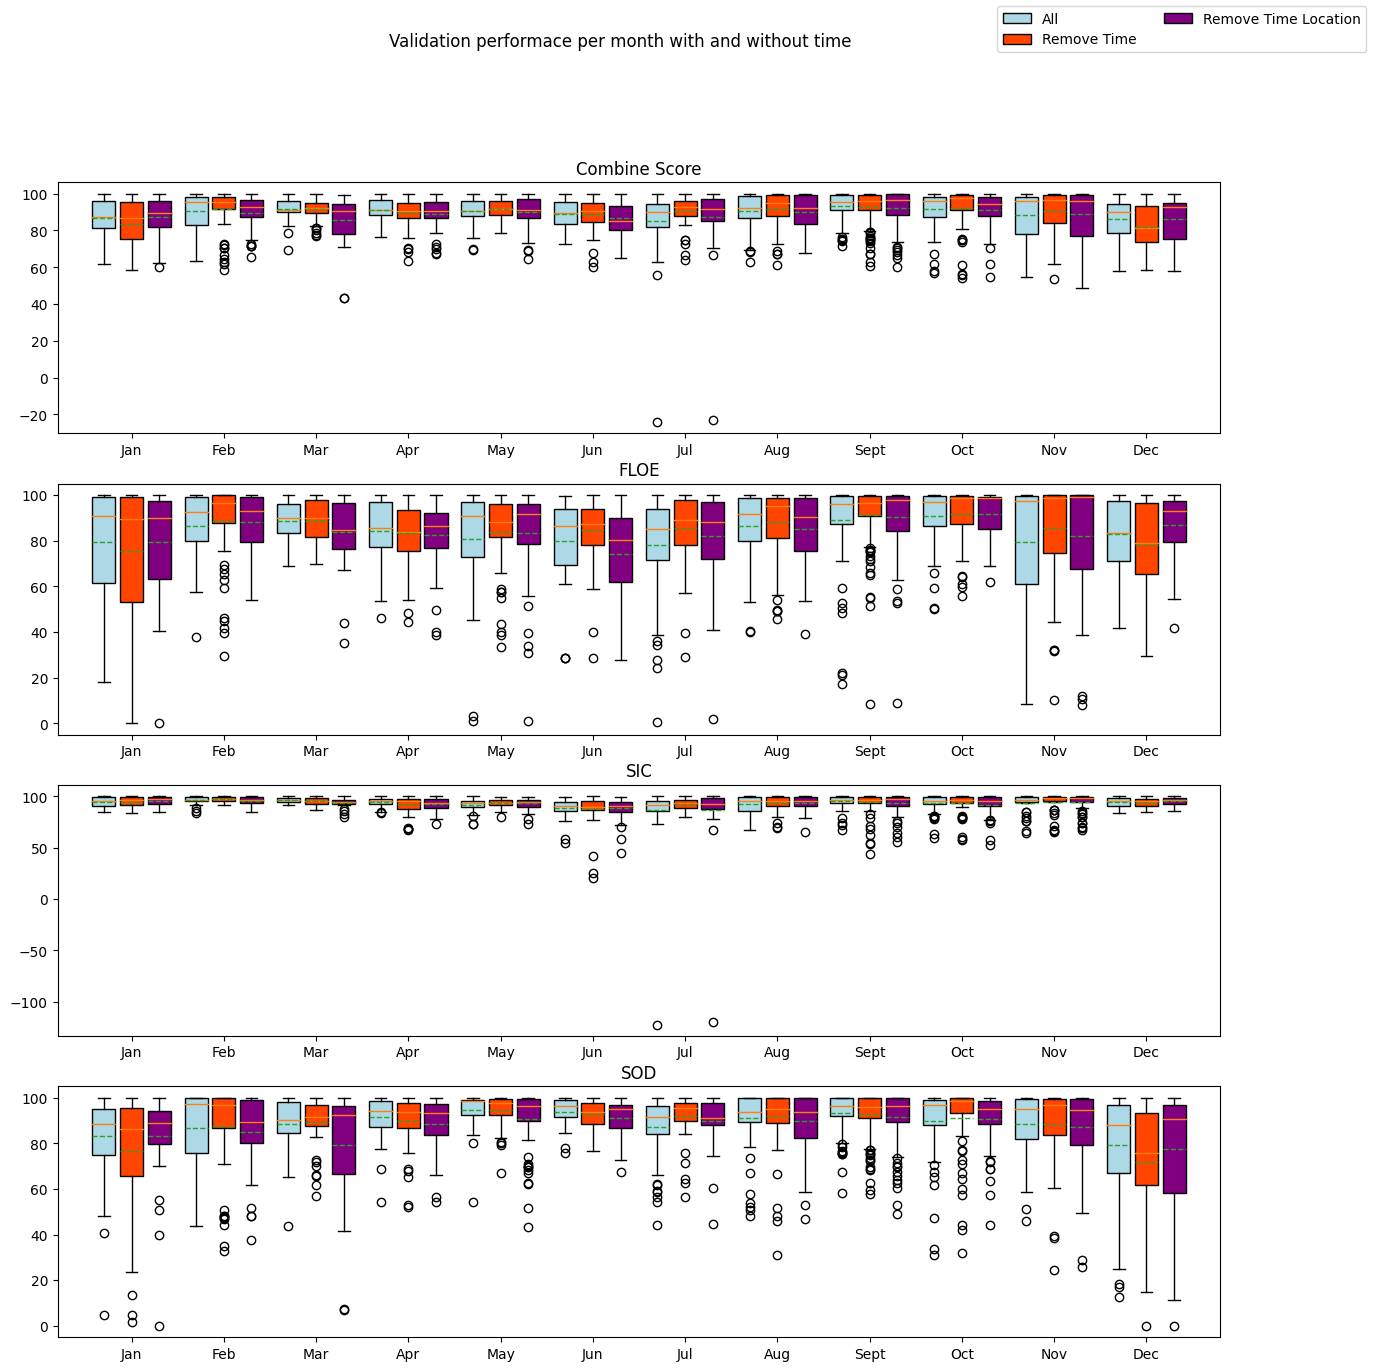

In [5]:
df_base = convert_to_df(base_mean_dic)
display(df_base)


df_remove_time = convert_to_df(remove_time_mean_dic)
display(df_remove_time)


df_remove_time_location = convert_to_df(remove_time_location_mean_dic)
display(df_remove_time_location)



bar_width = 0.25


x =  np.arange(len(df_base['months'].tolist()))



fig, axs = plt.subplots(4, 1, figsize=(15,15))
fig.suptitle('Validation performace per month with and without time')

bp1 = axs[0].boxplot(base_mean_dic['Combine Score']['array'],positions=x-1.2*bar_width, widths=bar_width, patch_artist=True,
               showmeans=True,meanline='True', boxprops=dict(facecolor='lightblue'))
bp2 = axs[0].boxplot(remove_time_mean_dic['Combine Score']['array'],positions=x+0.0*bar_width, widths=bar_width, patch_artist=True,
               showmeans=True, meanline='True', boxprops=dict(facecolor='orangered'))
bp3 = axs[0].boxplot(remove_time_location_mean_dic['Combine Score']['array'],positions=x+1.2*bar_width, widths=bar_width, patch_artist=True,
               showmeans=True, meanline='True', boxprops=dict(facecolor='purple'))

axs[0].set_xticks(x,labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'])
axs[0].set_title('Combine Score')

axs[1].boxplot(base_mean_dic['FLOE']['array'],positions=x-1.2*bar_width, widths=bar_width, 
               showmeans=True, meanline='True', patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[1].boxplot(remove_time_mean_dic['FLOE']['array'],positions=x+0.0*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='orangered'))
axs[1].boxplot(remove_time_location_mean_dic['FLOE']['array'],positions=x+1.2*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='purple'))

axs[1].set_xticks(x,labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'])
axs[1].set_title('FLOE')

axs[2].boxplot(base_mean_dic['SIC']['array'],positions=x-1.2*bar_width, widths=bar_width, 
               showmeans=True, meanline='True', patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[2].boxplot(remove_time_mean_dic['SIC']['array'],positions=x+0.0*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='orangered'))
axs[2].boxplot(remove_time_location_mean_dic['SIC']['array'],positions=x+1.2*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='purple'))

axs[2].set_xticks(x,labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'])
axs[2].set_title('SIC')


axs[3].boxplot(base_mean_dic['SOD']['array'],positions=x-1.2*bar_width, widths=bar_width, 
               showmeans=True, meanline='True', patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[3].boxplot(remove_time_mean_dic['SOD']['array'],positions=x+0.0*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='orangered'))
axs[3].boxplot(remove_time_location_mean_dic['SOD']['array'],positions=x+1.2*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='purple'))

axs[3].set_xticks(x,labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'])
axs[3].set_title('SOD')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['All', 'Remove Time', 'Remove Time Location'],ncols=2,loc='outside upper right')

plt.show()

In [4]:

path = 'ai4arctic/feature_selection_rerun_inference'
group = 'rerun_base'

base_mean_dic, base_relative_mean_dic = performace_per_month(path,group)


path = 'ai4arctic/feature_selection_rerun_inference'
group = 'remove_amsr2'

remove_amsr2_mean_dic, remove_amsr2_relative_mean_dic = performace_per_month(path,group)


# path = 'ai4arctic/feature_selection_time_rerun'
# group = 'HH_HV_Time'

# Time_mean_dic, Time_relative_mean_dic = performace_per_month(path,group)


# path = 'ai4arctic/feature_selection_base'
# group = 'HH_HV_Time_Location'

# Time_Location_mean_dic, Time_Location_relative_mean_dic = performace_per_month(path,group)

wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


In [ ]:

df_base = convert_to_df(base_mean_dic)
display(df_base)


df_remove_amsr2 = convert_to_df(remove_amsr2_mean_dic)
display(df_remove_amsr2)

In [3]:

path = 'ai4arctic/feature_selection_enviroment_rerun'
group = 'HH_HV_only'

HH_HV_mean_dic, HH_HV_relative_mean_dic = performace_per_month(path,group)


path = 'ai4arctic/feature_selection_rerun_inference'
group = 'HH_HV_AMSR2_All'

HH_HV_AMSR2_mean_dic, HH_HV_AMSR2_relative_mean_dic = performace_per_month(path,group)

wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


In [4]:
df_HH_HV = convert_to_df(HH_HV_mean_dic)
display(df_HH_HV)


df_HH_HV_AMSR2 = convert_to_df(HH_HV_AMSR2_mean_dic)
display(df_HH_HV_AMSR2)

,months,Combine Score Avg,Combine Score Std,SIC Avg,SIC Std,SOD Avg,SOD Std,FLOE Avg,FLOE Std,sample _number
0,1,77.106860,16.642786,91.125078,8.490607,67.146813,28.151841,68.990985,28.744147,64
1,2,87.362734,13.930007,97.010776,2.602643,79.588388,24.829383,83.615286,21.056646,49
2,3,86.295239,12.075546,95.034000,4.271380,77.088848,27.237464,87.230131,11.380937,46
3,4,87.622311,8.600215,89.779262,8.944164,87.580705,11.411064,83.391672,12.777634,61
4,5,86.773521,11.877696,90.542890,7.554138,85.502261,16.639593,81.777301,22.081163,73
5,6,86.509907,9.483437,88.182884,12.152354,87.180070,9.334730,81.823325,19.121936,43
6,7,82.078969,19.765074,84.394508,26.749611,83.401708,17.614115,74.802400,20.477775,65
7,8,87.397505,14.257882,90.435394,11.372527,86.220151,18.720941,83.676293,19.724826,99
8,9,92.459363,11.422818,94.598920,8.156861,91.995806,13.662884,89.107487,18.741730,113
9,10,90.269275,12.820471,91.758813,11.875330,88.442850,17.301641,90.943025,13.868728,80


,months,Combine Score Avg,Combine Score Std,SIC Avg,SIC Std,SOD Avg,SOD Std,FLOE Avg,FLOE Std,sample _number
0,1,85.415510,9.839127,93.000470,4.862842,80.839367,14.808838,79.397816,23.062815,49
1,2,89.522139,12.107579,96.642069,3.233179,83.953582,22.042248,86.419395,16.528631,43
2,3,89.124021,6.996691,94.759957,3.662401,84.044808,13.248435,88.010788,9.196838,47
3,4,88.629772,7.167475,93.724908,5.763670,86.399659,10.448177,82.900091,12.044060,44
4,5,88.579133,8.923303,92.564117,6.423353,90.264417,16.021493,77.238600,21.481409,60
5,6,90.137631,6.550223,91.073316,5.741467,94.182860,6.093328,80.175807,17.711426,57
6,7,87.779540,16.970403,89.175635,26.637631,89.426270,14.938795,81.693841,20.289071,63
7,8,90.251460,10.715196,93.076870,8.330483,89.266710,14.623946,86.569980,15.399838,100
8,9,93.638157,8.635625,94.947405,10.100214,93.736446,8.750827,90.823107,16.202899,121
9,10,90.591427,11.549559,92.950610,8.348399,88.188671,17.475135,90.678305,11.982923,82
